<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install joblib
import tensorflow as tf 
import pickle
#from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [148]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## 64 BIT (2253,4016)
'''
with open('/content/drive/My Drive/ffeatures64.bin','rb') as file:
  features = pickle.load(file)
with open('/content/drive/My Drive/flabels64.bin','rb') as file:
  labels = pickle.load(file)
'''

In [0]:
## 32 BIT (2253,1035)

features = joblib.load('/content/features32.pkl')
labels = joblib.load('/content/labels32.pkl')

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''

In [41]:
# print(features[0])
# print(len(features[0]))
# print(len(features))
print(np.shape(features))

(2253, 267)


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [174]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4337869771333168358
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12678707933625012255
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17369204445355114065
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8546171551515789884
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
x = tf.placeholder(shape = (None,1035), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1035, 500)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,500)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((500,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


                

In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl = tf.add(tf.matmul(hidl,wo),bo,name = 'output')

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.3*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

In [181]:
train=[]
val=[]
with tf.device('/device:CPU:0'):
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,1000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
        
        ##TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      z= sess.run([loss,op_train], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      ##VALIDATION LOSS
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    
    simple_save(sess,'/content/drive/My Drive/Custom_Models/model1000_32',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    

2188.2551	1791.0945
1839.4598	471.1087
394.49942	975.8861
407.24332	600.0703
1721.482	1355.796
1174.7644	1076.4741
1212.7787	1293.1244
1004.52313	723.40735
1014.7914	1658.5359
331.73105	351.2485
257.9049	1267.4983
181.93282	359.35962
422.54608	272.01135
982.5816	1459.4905
384.91055	296.6114
1620.4448	882.4218
2680.8345	1881.7393
1532.7869	641.0768
467.24847	198.11816
165.20184	1232.3683
349.62558	1156.6731
792.80804	854.70435
1288.5073	441.48343
553.3688	1779.7205
762.82935	577.1458
1131.3679	785.0221
917.14136	829.8377
1224.3698	779.3963
2367.801	478.79276
755.32947	800.58954
1331.1622	1305.6869
884.60815	271.09692
901.19806	253.83221
1249.0911	258.8217
508.5551	652.17755
680.9291	776.7225
235.57991	1328.3837
603.90466	1399.9622
208.99908	891.8061
226.6354	769.9752
259.42712	753.8445
1173.6495	1960.169
562.9608	1085.0286
846.653	265.82416
325.86697	281.90033
706.4546	199.25055
722.29944	821.15607
352.87097	752.6512
270.59506	959.0657
638.3772	508.23813
219.31116	243.97273
1054.8918	26

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_32.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

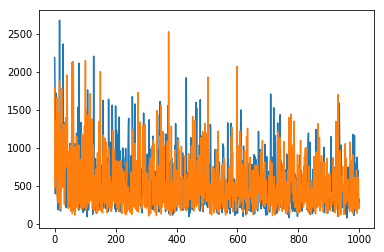

In [182]:
plt.plot(train)
plt.plot(val)

In [183]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(1035, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(500, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_updatedloss.pb', 'rb') as f:
  g1 = f.read()
with open('/content/drive/My Drive/Custom_Models/graph1000.pb', 'rb') as f:
  g2 = f.read()

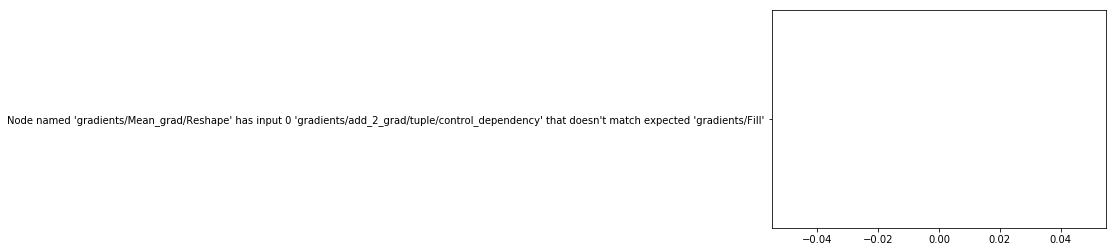

In [146]:
diff = pywrap_tensorflow.EqualGraphDefWrapper(g1,g2) 
#plt.plot(diff)